In [1]:
!pip install xgboost

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import ROOT as R
import uproot

import import_ipynb
import setPath
from os import listdir
from os.path import isfile, join
from Input.OpenDataPandaFramework13TeV import *

import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import pyStats

import xgboost as xgb
from sklearn import datasets

%jsroot on
%matplotlib inline

R.gInterpreter.ProcessLine('#include "Analysis/AnalysisSelector.cpp"')


Welcome to JupyROOT 6.24/02
importing Jupyter notebook from setPath.ipynb
importing Jupyter notebook from /storage/galaxy/jobs_directory/005/5239/working/jupyter/Input/OpenDataPandaFramework13TeV.ipynb
This library contains handy functions to ease the access and use of the 13TeV ATLAS OpenData release

getBkgCategories()
	 Dumps the name of the various background cataegories available 
	 as well as the number of samples contained in each category.
	 Returns a vector with the name of the categories

getSamplesInCategory(cat)
	 Dumps the name of the samples contained in a given category (cat)
	 Returns dictionary with keys being DSIDs and values physics process name from filename.

getMCCategory()
	 Returns dictionary with keys DSID and values MC category

initialize(indir)
	 Collects all the root files available in a certain directory (indir)

getSkims(indir)
	 Prints all available skims in the directory



Setting luminosity to 10064 pb^-1

###############################
#### Backgrou

0

In [3]:
# Preliminaries ensuring the plots aren't too small
matplotlib.rcParams.update({'font.size': 20})
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [4]:
# Preliminaries ensuring the plots aren't too small
# Yes, we have to do it twice... don't ask.
matplotlib.rcParams.update({'font.size': 20})
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [5]:
opendatadir = "/storage/shared/data/fys5555/ATLAS_opendata/"
analysis = "4lep"

In [6]:
# Manipulate the simulated Monte Carlo data and choose which background and signal samples you want to use
mcfiles = initialize(opendatadir+"/"+analysis+"/MC")
datafiles = initialize(opendatadir+"/"+analysis+"/Data")
allfiles = z = {**mcfiles, **datafiles}
Backgrounds = getBkgCategories()

Backgrounds.remove('Zjets')
Backgrounds.remove('Wjets')
Backgrounds.remove('Wjetsincl')

signal = 'Higgs'


####################################################################################################
SIGNAL SAMPLES
####################################################################################################
WARNING 	 File for SlepSlep_direct_200p5_1p0_2L8 not found in /storage/shared/data/fys5555/ATLAS_opendata//4lep/MC
WARNING 	 File for SlepSlep_direct_100p5_1p0_2L8 not found in /storage/shared/data/fys5555/ATLAS_opendata//4lep/MC
WARNING 	 File for SlepSlep_direct_500p5_1p0_2L8 not found in /storage/shared/data/fys5555/ATLAS_opendata//4lep/MC
WARNING 	 File for SlepSlep_direct_300p5_1p0_2L8 not found in /storage/shared/data/fys5555/ATLAS_opendata//4lep/MC
WARNING 	 File for SlepSlep_direct_100p0_50p0_2L8 not found in /storage/shared/data/fys5555/ATLAS_opendata//4lep/MC
WARNING 	 File for SlepSlep_direct_500p0_100p0_2L8 not found in /storage/shared/data/fys5555/ATLAS_opendata//4lep/MC
WARNING 	 File for SlepSlep_direct_200p0_100p0_2L8 not found in /storage/shared/data/fys55

In [7]:
files = []
for Category in Backgrounds:
    Type = mcfiles[Category]['type']
    for File in mcfiles[Category]['files']:
        files.append(File)
        
for File in datafiles['data']['files']:
    files.append(File)

In [8]:
chain = R.TChain('mini') 

for File in files:
        chain.Add(File) 

In [9]:
if not os.path.exists('./Histograms'):
    os.makedirs('./Histograms')
if not os.path.exists('./Histograms/MC/'):
    os.makedirs('./Histograms/MC')
if not os.path.exists('./Histograms/Data/'):
    os.makedirs('./Histograms/Data')

In [10]:
selection = R.AnalysisSelector(chain, analysis)

Info in <TUnixSystem::ACLiC>: creating shared library /storage/galaxy/jobs_directory/005/5239/working/jupyter/project3/./Analysis/HZZAnalysis_C.so


Process the chains for both the Monte Carlo and Data at the same time, the relevant histograms and features for machine learning can be aquired by calling the TChain Process class from the SelectorProxy class via the Selector function

- R.SelectorProxy().Selector()."function"

The relevant functions are

- .GetHistogram((string) Category)

In [11]:
%%time

selection.Process(signal)

CPU times: user 16 s, sys: 408 ms, total: 16.4 s
Wall time: 16.7 s
-------------------------------------------
Processing MC and Data
Number of events to process: 1596789
-------------------------------------------
Total number of processed events: 1596789
Number of selected events: 1078230
Number of jets: 872768


Warning in <TROOT::Append>: Replacing existing TH1: h_mllll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_meeee (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_muuuu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_meeuu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mllll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_meeee (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_muuuu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_meeuu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_mllll (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_meeee (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_muuuu (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h_meeuu (Pote

In [12]:
# Get the features from the processed Selector class
tree = selection.Selector().GetTree()

# convert the tree into a RDataFrame object
df = R.RDataFrame(tree)

# Then convert that into a pandas dataframe
df = pd.DataFrame(df.AsNumpy(0))

In [13]:
# Shuffle the dataframe too randomize the position of each process
df = df.sample(frac=1).reset_index(drop=True)

df

,eventID,n_el,n_mu,n_jet,weight,lep1_pt,lep2_pt,lep3_pt,lep4_pt,lep1_eta,...,jet1_phi,jet2_phi,jet3_phi,jet4_phi,ev_mll,ev_mllll,met_pt,met_phi,ev_mt2,label
0,8158504,2,2,1,0.000000,64876.386719,57577.941406,35902.539062,14581.375977,-1.847720,...,-999.0,-999.0,-999.0,-999.0,113565.105321,177395.987400,20816.824219,0.842615,117.867769,0
1,8451177,4,0,2,0.000087,69307.593750,57635.121094,32546.634766,9067.855469,-0.364002,...,-999.0,-999.0,-999.0,-999.0,196434.720234,246540.602532,14343.721680,-1.301261,3848.478300,0
2,106992,2,2,1,0.000071,169229.171875,58085.476562,31036.222656,7081.755371,-0.863307,...,-999.0,-999.0,-999.0,-999.0,91070.756710,125086.863596,34525.132812,3.129848,34660.938658,1
3,14340608,4,0,1,0.000177,105243.382812,52842.367188,43608.347656,15285.817383,0.224163,...,-999.0,-999.0,-999.0,-999.0,103968.536944,224605.991255,25049.833984,-1.204110,33513.748963,0
4,12962213,0,4,0,0.001622,148796.015625,98889.093750,95281.085938,43816.097656,-0.825962,...,-999.0,-999.0,-999.0,-999.0,289847.987734,529337.360488,4484.546875,-1.744160,6356.118688,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077946,5488316,2,2,0,0.001646,47362.746094,44606.742188,33386.921875,26888.240234,-0.530106,...,-999.0,-999.0,-999.0,-999.0,85377.593326,180802.819250,13166.817383,-2.090909,11935.784783,0
1077947,10863447,0,4,0,0.001823,61202.042969,34026.054688,28770.476562,20253.580078,-1.108482,...,-999.0,-999.0,-999.0,-999.0,82321.834694,153732.215595,11819.821289,3.003888,13891.046094,0
1077948,10294021,4,0,2,0.000178,213107.156250,149820.468750,47749.855469,21760.830078,-2.208004,...,-999.0,-999.0,-999.0,-999.0,354745.111921,447970.066850,8069.622559,2.086590,0.598320,0
1077949,5220828,0,4,2,0.000373,59019.578125,55933.921875,52506.164062,48990.507812,-0.917565,...,-999.0,-999.0,-999.0,-999.0,63253.421756,220679.940767,22377.750000,-0.476916,44379.353574,0


In [14]:
# Rescaling of weights and make sure all weights are positive

weights = df.weight

weights = np.abs(weights)*np.sum(weights)/np.sum(np.abs(weights))


In [15]:
# Set the size of each portion of data
test_size = 200000
# Convert to numpy arrays (input)
# Separate into data, weights, target
Y = np.array(df.label)
X = np.array(df.drop(["label", "weight", "eventID"],axis=1)) # Remove variables that should NOT be trained on
W = np.array(weights) * float(test_size) / len(Y) # Ensure the weights are scaled to the size of the test portion

In [16]:
# Build training, validation & evaluation samples (test_size events for each of signal and background per sample)
size = test_size
X_train = np.concatenate((X[Y==0][0:size],X[Y==1][0:size]), axis=0)
w_train = np.concatenate((W[Y==0][0:size],W[Y==1][0:size]), axis=0)
y_train = np.concatenate((Y[Y==0][0:size],Y[Y==1][0:size]), axis=0)
X_valid = np.concatenate((X[Y==0][size:size*2],X[Y==1][size:size*2]), axis=0)
y_valid = np.concatenate((Y[Y==0][size:size*2],Y[Y==1][size:size*2]), axis=0)
X_eval = np.concatenate((X[Y==0][size*2:size*3],X[Y==1][size*2:size*3]), axis=0)
y_eval = np.concatenate((Y[Y==0][size*2:size*3],Y[Y==1][size*2:size*3]), axis=0)
# Get the sums of the weights for signal and background events 
sum_wsig = sum( w_train[i] for i in range(len(y_train)) if y_train[i] == 1.0  )
sum_wbkg = sum( w_train[i] for i in range(len(y_train)) if y_train[i] == 0.0  )

In [17]:
%%time

# Set up the BDT classifier
xgbclassifier = xgb.XGBClassifier(
    max_depth=6,
    n_estimators=200,
    learning_rate=0.1,
    n_jobs=4,
    scale_pos_weight=sum_wbkg/sum_wsig,
    objective='binary:logistic',
    missing=-999.0,) 

xgbclassifier.fit(X_train,y_train, sample_weight=w_train) 

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:04:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 2min 37s, sys: 511 ms, total: 2min 37s
Wall time: 2min 38s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=-999.0,
              monotone_constraints='()', n_estimators=200, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=9.538043396658695,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [18]:
# Test the BDT performance using the validation dataset
y_pred = xgbclassifier.predict( X_valid ) # The actual signal/background predictions. Note that we don't actually use them
y_pred_prob = xgbclassifier.predict_proba( X_valid ) # The BDT outputs for each event

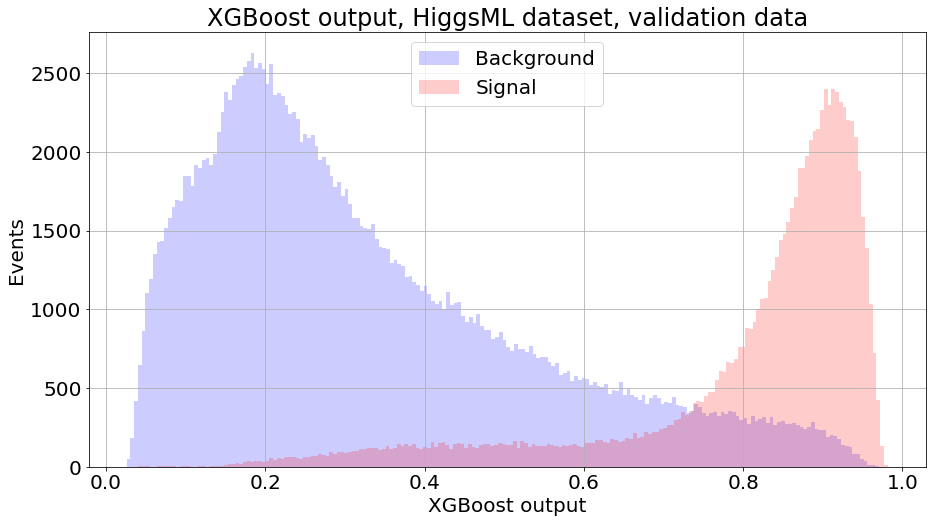

<Figure size 1080x576 with 0 Axes>

In [19]:
#  histogram of the BDT outputs
nb, bins, patches = plt.hist(y_pred_prob[:,1][y_valid==0], 200, facecolor='blue', alpha=0.2,label="Background")
ns, bins, patches = plt.hist(y_pred_prob[:,1][y_valid==1], 200, facecolor='red', alpha=0.2, label="Signal")

plt.xlabel('XGBoost output')
plt.ylabel('Events')
plt.title('XGBoost output, HiggsML dataset, validation data')
plt.grid(True)
#plt.yscale('log')
plt.legend()
plt.show()

plt.savefig('validation.pdf')

In [20]:
s = ns.astype(np.int64)
b = nb.astype(np.int64)


In [21]:
points = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]

sigma = []
for point in points:
    i = int(201*point)
    print(i, s[i], b[i])
    Z = np.sqrt(2*((s[i] + b[i])*np.log(1 + s[i]/b[i]) - s[i]))
    sigma.append(Z)
    
sigma

20 5 1947
40 61 2375
60 115 1579
80 151 1096
100 162 808
120 154 549
140 247 459
160 762 352
180 2134 243
198 132 11


[0.11326645430985872,
 1.2463920021470896,
 2.8599505100857696,
 4.461978771930317,
 5.523041297517719,
 6.2964578235222675,
 10.675102750557866,
 32.29298706550676,
 81.0780734612595,
 21.669691189170173]

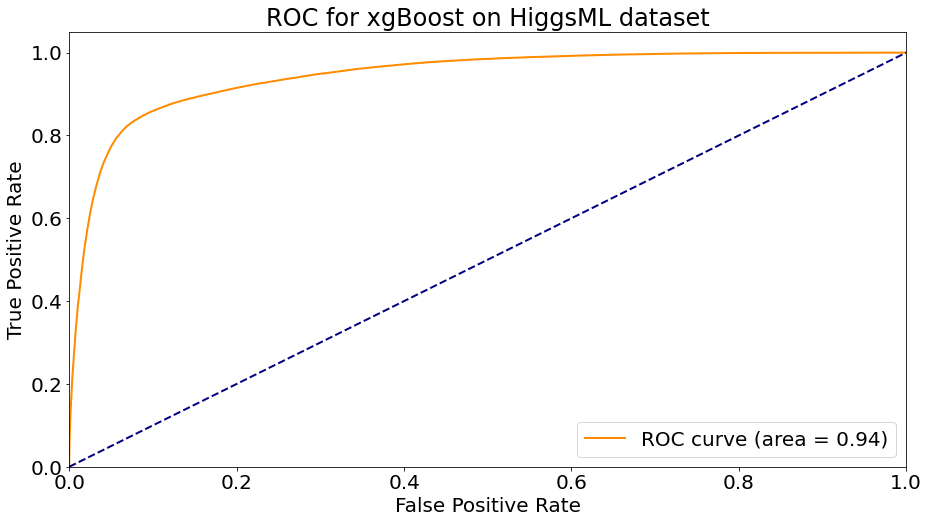

In [22]:
from sklearn.metrics import roc_curve,auc
fpr, tpr, thresholds = roc_curve(y_valid,y_pred_prob[:,1], pos_label=1)
roc_auc = auc(fpr,tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for xgBoost on HiggsML dataset')
plt.legend(loc="lower right")
plt.show()

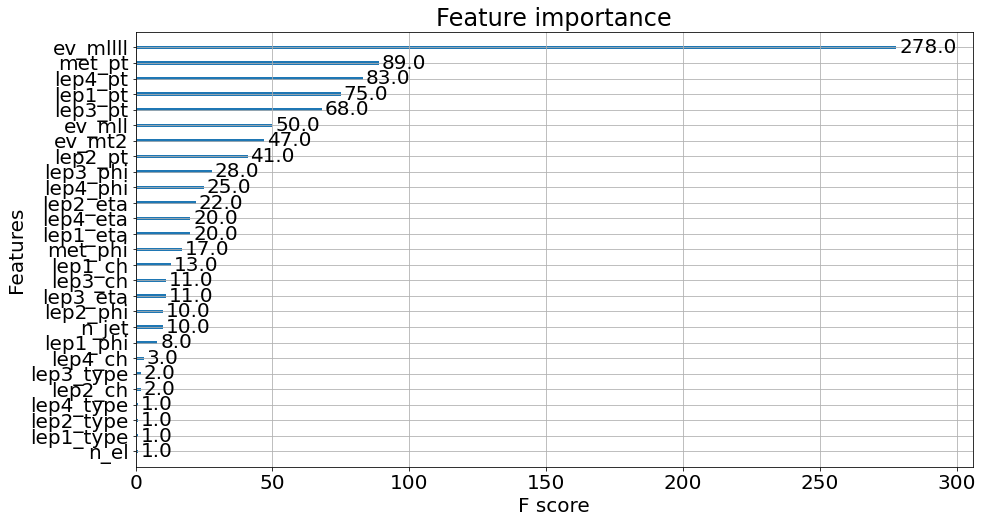

In [23]:
x = df.drop(["label", "weight", "eventID"],axis=1)

# Put the features inside a dictionary with an index
features = {}
for i in range(len(x.keys())):
    features[i] = x.keys()[i]

# Plot variable importance
fig = xgb.plot_importance(xgbclassifier)

# Go through the labels figure and change them to their correpsonding feature
labels = [item.get_text() for item in fig.get_yticklabels()]
for i in range(len(labels)):
    val = int(labels[i][1:])
    feature = features[val]
    labels[i] = feature
    
fig.set_yticklabels(labels) # Set y-tick labels

fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
plt.show()

## Setup the plots

In [24]:
colours = {}

colours["Diboson"] = R.kGreen; 
colours["Zjets"] = R.kYellow; 
colours["ttbar"] = R.kRed;
colours["singleTop"] = R.kBlue-7; 
colours["Wjets"] = R.kBlue+3; 
colours["topX"] = R.kOrange+1; 
colours["Higgs"] = R.kMagenta; 
colours["Wjetsincl"] = R.kBlue-10;
colours["Zjetsincl"] = R.kYellow-9;

### Get histograms from C++ class

First reshuffle the backgrounds list with Higgs at the top and then Diboson, just for better look

In [25]:
Backgrounds.remove('Higgs')

In [26]:
Backgrounds.remove('Diboson')

Backgrounds.append('Diboson')
Backgrounds.append('Higgs')

In [27]:
H_mllll = {}

H_mllll['b'] = R.TH1D()
H_mllll['s+b'] = R.TH1D()
for bkg in Backgrounds:
    H_mllll[bkg] = R.TH1D()
    
    H_mllll[bkg].SetNameTitle('H_mllll', '4L invariant mass')
    H_mllll[bkg].SetBins(24, 80, 170)
    
    H_mllll[bkg].Reset()
    
    H_mllll[bkg].Add(selection.Selector().GetHistogram('mllll', bkg)) # Aquire the specific histogram from the Selector pointer from the SelectorProxy class   
    
    H_mllll['s+b'] = R.TH1D()
    H_mllll['s+b'].SetNameTitle('H_mllll', '4L invariant mass')
    H_mllll['s+b'].SetBins(24, 80, 170)
    H_mllll['s+b'].Reset()
    H_mllll['s+b'].Add(selection.Selector().GetHistogram('mllll', bkg))
    
    if bkg != signal:
        H_mllll['b'] = R.TH1D()
        H_mllll['b'].SetNameTitle('H_mllll', '4L invariant mass')
        H_mllll['b'].SetBins(24, 80, 170)
        H_mllll['b'].Reset()
        H_mllll['b'].Add(selection.Selector().GetHistogram('mllll', bkg))
    

In [28]:
H_mllll_d = R.TH1D()

H_mllll_d.SetNameTitle('H_mllll', '4L invariant mass')
H_mllll_d.SetBins(24, 80, 170)

H_mllll_d.Reset()

H_mllll_d.Add(selection.Selector().GetHistogram('mllll', 'data'))

True

### Create the plots

In [29]:
for bkg in Backgrounds:
    #if bkg == 'Higgs':
     #   H_mllll[bkg].SetLineColor(colours[bkg]); 
        #H_mllll[bkg].SetMarkerStyle(R.kFullCircle); 
      #  H_mllll[bkg].SetMarkerColor(colours[bkg]); 
       # H_mllll[bkg].SetLineStyle(2)
    
    #else:
    H_mllll[bkg].SetFillColor(colours[bkg]); 

    H_mllll[bkg].SetLineColor(colours[bkg]); 


In [30]:
stack_mllll = R.THStack("4L invariant mass", "");

for bkg in Backgrounds: 
    stack_mllll.RecursiveRemove(H_mllll[bkg]); ## Remove previously stacked histograms  
    
    stack_mllll.Add(H_mllll[bkg]); 
    

In [31]:
H_bkg = R.TH1D()

H_bkg.SetNameTitle('H_mllll', '4L invariant mass')
H_bkg.SetBins(24, 80, 170)

H_bkg.Reset()

Backgrounds.remove('Higgs')
for bkg in Backgrounds:
    H_bkg.Add(H_mllll[bkg])
    
Backgrounds.append('Higgs')

In [32]:
H_mllll_d.SetLineColor(R.kBlack); 
H_mllll_d.SetMarkerStyle(R.kFullCircle); 
H_mllll_d.SetMarkerColor(R.kBlack); 

In [33]:
R.gStyle.SetLegendBorderSize(0); ## Remove (default) border around legend 
leg = R.TLegend(0.65, 0.60, 0.9, 0.85); 

leg.Clear();
for bkg in Backgrounds: 
    leg.AddEntry(H_mllll[bkg], bkg, "f")  ## Add your histograms to the legend
leg.AddEntry(H_mllll_d, "Data", "lep") 

In [34]:
R.gROOT.SetStyle("ATLAS")

C = R.TCanvas("c", "c", 700, 750)

upper_pad = R.TPad("upper_pad", "", 0, 0.35, 1, 1)
lower_pad = R.TPad("lower_pad", "", 0, 0, 1, 0.35)
for p in [upper_pad, lower_pad]:
    p.SetLeftMargin(0.14)
    p.SetRightMargin(0.05)
    p.SetTickx(False)
    p.SetTicky(False)
upper_pad.SetBottomMargin(0)
lower_pad.SetTopMargin(0)
lower_pad.SetBottomMargin(0.3)
 
upper_pad.Draw()
lower_pad.Draw()

upper_pad.cd()

R.gPad.SetLogy(0) ## Set logarithmic y-axis

stack_mllll.Draw("hist"); 
stack_mllll.SetMaximum(30); 
stack_mllll.SetMinimum(0.0001); 
stack_mllll.GetYaxis().SetTitle("# events");
stack_mllll.GetYaxis().SetTitleOffset(1.3); 
stack_mllll.GetXaxis().SetTitle("m_{4l} (GeV)");
stack_mllll.GetXaxis().SetTitleOffset(1.3);
H_mllll_d.Draw("same E"); 
leg.Draw();

lower_pad.cd()

ratiobkg = R.TH1I("zero", "", 100, 80, 170)
ratiobkg.SetLineColor(R.kBlue)
ratiobkg.SetLineStyle(2)
ratiobkg.SetLineWidth(2)
ratiobkg.SetMinimum(-9.9999)
ratiobkg.SetMaximum(9.9999)
ratiobkg.GetXaxis().SetLabelSize(0.08)
ratiobkg.GetXaxis().SetTitleSize(0.12)
ratiobkg.GetXaxis().SetTitleOffset(1.0)
ratiobkg.GetYaxis().SetLabelSize(0.08)
ratiobkg.GetYaxis().SetTitleSize(0.09)
ratiobkg.GetYaxis().SetTitle("Data - Bkg")
ratiobkg.GetYaxis().CenterTitle()
ratiobkg.GetYaxis().SetTitleOffset(0.7)
ratiobkg.GetYaxis().SetNdivisions(503, True)
ratiobkg.GetYaxis().ChangeLabel(-1, -1, 0)
ratiobkg.GetXaxis().SetTitle("m_{llll} [GeV]")
ratiobkg.Draw("AXIS")

line = R.TLine(80, 0, 170, 0)
line.SetLineWidth(2)
line.SetLineStyle(2)
line.SetLineColor(R.kBlue)
line.Draw()
 
ratiodata = H_mllll_d.Clone()
ratiodata.Add(H_bkg, -1)
for i in range(1, H_mllll_d.GetNbinsX()):
    ratiodata.SetBinError(i, H_mllll_d.GetBinError(i))
ratiodata.Draw("E SAME")

C.Draw();

In [35]:
C = R.TCanvas("c", "c", 700, 750)

w = R.RooWorkspace('w')

g = w.factory('Gaussian::g(x[117.5,128.5],mean[118,130],sigma[0.1,50])')

x = w.var('x')
sigma = w.var('sigma')
mean = w.var('mean')

data = R.RooDataHist("data", "data", x, H_mllll['s+b'])

nll = g.createNLL(data)

minimizer = R.RooMinimizer(nll)
minimizer.minimize('Minuit2')

pll_mean = nll.createProfile(mean)

frame = mean.frame()

tmp = nll.plotOn(frame, R.RooFit.ShiftToZero())
p = tmp.getObject(0)

frame.Draw()

C.Draw()


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data): fit range of variable x expanded to nearest bin boundaries: [117.5,128.5] --> [117.5,128.75]
[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_g_FOR_OBS_x with 0 entries
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 mean         1.24000e+02  1.20000e+00    1.18000e+02  1.30000e+02
     2 sigma        2.50500e+01  4.99000e+00    1.00000e-01  5.00000e+01
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 *

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <ROOT::Math::FitConfig::CreateMinimizer>: Could not create the Minuit2 minimizer. Try using the minimizer Minuit


In [36]:
p.interpolate(122.08)


0.9948948261472275

In [37]:
print(mean.getValV(), mean.getError(), mean.getErrorHi(), mean.getErrorLo())

print(125/mean.getValV())

123.82399403254092 1.2750035022716588 1.2750035022716588 -1.2750035022716588
1.0094973997297327


### Statistical analysis

In [38]:
H_mllll_d.GetEntries()

279.0

In [39]:
bkgs = Backgrounds
bkgs.remove('Higgs')

In [40]:
b = 0
b_err = 0
for bkg in bkgs:
    for i in range(11,14):
        b += H_mllll[bkg].GetBinContent(i)
        b_err += H_mllll[bkg].GetBinError(i)**2
    
b_err = np.sqrt(b_err)
    
s = H_mllll['Higgs'].GetBinContent(11)
s += H_mllll['Higgs'].GetBinContent(12)
s += H_mllll['Higgs'].GetBinContent(13)

print(s+b,b)

Z = np.sqrt(2*((s + b)*np.log(1 + s/b) - s))
Z

18.250661152898097 10.90181971275501


2.0274149395656136

In [41]:
n_obs = int(H_mllll_d.GetBinContent(11))
n_obs += int(H_mllll_d.GetBinContent(12))
n_obs += int(H_mllll_d.GetBinContent(13))

Z = np.sqrt(2*(n_obs*np.log(n_obs/b) - n_obs + b))
Z

2.216526837118688

In [42]:
sig_eff = selection.Selector().GetSignalEfficiency()


In [43]:
Z = pyStats.countingExperimentWithBkgCorr(name='4L', intLum=10.06, intLumUnc=0.37)

n_obs = 0
b = 0; b_err = 0
for i in range(11,14):
    n_obs += int(H_mllll_d.GetBinContent(i))
    for bkg in bkgs:
        b += H_mllll[bkg].GetBinContent(i)
        b_err += H_mllll[bkg].GetBinError(i)**2
Z.addChannel('Signal region', bkg=b, bkgUncUncorr=0, bkgUncCorr=b_err, Nobs=n_obs, eff=sig_eff)

n_obs = 0
b = 0; b_err = 0
for i in range(1,4):
    n_obs += int(H_mllll_d.GetBinContent(i))
    for bkg in bkgs:
        b += H_mllll[bkg].GetBinContent(i)
        b_err += H_mllll[bkg].GetBinError(i)**2
Z.addChannel('Control region', bkg=b, bkgUncUncorr=0, bkgUncCorr=b_err, Nobs=n_obs, eff=0)
Z.setPriors(bkg='gauss');

print(Z)

print('Significance =', Z.getSignificance())

---------------------------
Counting experiment "4L"
---------------------------
Int. luminosity = 10.06 +/- 0.37
---------------------------
Channel "Signal region":
   Background = 10.90181971275501 +/- 0(uncorr) +/- 0.8625128143870154(corr)
   Observed events = 19
   Signal efficiency = 0.669409453868866 +/- 0.0
Channel "Control region":
   Background = 32.94662171836356 +/- 0(uncorr) +/- 0.07936952152976619(corr)
   Observed events = 27
   Signal efficiency = 0 +/- 0.0

Significance = 2.1456760638260155


In [44]:
Z.getBayesianLimit()

2.602611799306581

In [45]:
"""m2sig,m1sig,expected,p1sig,p2sig = Z.getBayesianExpectedLimit();
print( "\nExpected limit and bands:" );
print( "  -2sigma                 -1sigma                 median                +1sigma                +2sigma" );
print( m2sig, "   ", m1sig, "   ", expected, "   ", p1sig, "   ", p2sig );"""

'm2sig,m1sig,expected,p1sig,p2sig = Z.getBayesianExpectedLimit();\nprint( "\nExpected limit and bands:" );\nprint( "  -2sigma                 -1sigma                 median                +1sigma                +2sigma" );\nprint( m2sig, "   ", m1sig, "   ", expected, "   ", p1sig, "   ", p2sig );'